## Notebook version of the submission

In [1]:
import folktables
from folktables import ACSDataSource
import numpy as np

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing 

import pandas as pd

from sklearn.model_selection import train_test_split
import sklearn

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [2]:
# TODO: have it load data from file when False
GET_DATA = False

SENSITIVE_ATTRIBUTE = 'SEX'


#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
    'AGEP', #age; for range of values of features please check Appendix B.4 of 
            #Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
    'SCHL', #educational attainment
    'MAR', #marital status
    'RELP', #relationship
    'DIS', #disability recode
    'ESP', #employment status of parents
    'CIT', #citizenship status
    'MIG', #mobility status (lived here 1 year ago)
    'MIL', #military service
    'ANC', #ancestry recode
    'NATIVITY', #nativity
    'DEAR', #hearing difficulty
    'DEYE', #vision difficulty
    'DREM', #cognitive difficulty
    'SEX', #sex
    'RAC1P', #recoded detailed race code
    'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group=SENSITIVE_ATTRIBUTE, 
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

if GET_DATA:
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True) #data for California state
else:
    data = pd.read_csv('data/2018/1-Year/psam_p06.csv')
    acs_data = data


features, label, group = ACSEmployment.df_to_numpy(acs_data)
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label

In [3]:
# Once the data is loaded, we need to partition it into train, validation, and test sets.
# We want 70/30 train/test split, and 20% of the training set to be used for validation.
# We want to randomly split the training set 5 times.
# We also want this data to be in the format that AIF360 expects, which should also handle preprocessing.

train, test = train_test_split(data, test_size=0.3, random_state=42)
train_val_splits = dict()
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 2}]

train_dataset = StandardDataset(train, 'label', favorable_classes = favorable_classes,
                        protected_attribute_names = protected_attribute_names,
                        privileged_classes = privileged_classes)

test = StandardDataset(test, 'label', favorable_classes = favorable_classes,
                        protected_attribute_names = protected_attribute_names,
                        privileged_classes = privileged_classes)

def get_train_val_splits(train, reweigh = False):
    for i in range(5):
        # Shuffle the training set
        train = sklearn.utils.shuffle(train)
        train_split, val_split = train_test_split(train, test_size=0.2, random_state=42)
        train_split = StandardDataset(train_split, 'label', favorable_classes = favorable_classes,
                                protected_attribute_names = protected_attribute_names,
                                privileged_classes = privileged_classes)
        val_split = StandardDataset(val_split, 'label', favorable_classes = favorable_classes,
                            protected_attribute_names = protected_attribute_names,
                            privileged_classes = privileged_classes)
        if reweigh:
            # Reweigh the training split
            RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
            RW.fit(train_split)
            train_split = RW.transform(train_split)
            
        train_val_splits[i] = (train_split, val_split)
    return train_val_splits

In [4]:
get_train_val_splits(train, reweigh=False)
print("phase 2")
get_train_val_splits(train, reweigh=True)

phase 2


{0: (               instance weights features                                       \
                                                                                  
                                      AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG   
  instance names                                                                  
  132133                 1.084362     58.0  22.0  1.0   0.0  2.0  0.0  1.0  1.0   
  187804                 0.906608     49.0  16.0  1.0   1.0  2.0  0.0  5.0  1.0   
  19160                  0.906608     17.0  12.0  5.0   2.0  2.0  7.0  1.0  1.0   
  151496                 1.121276     19.0  19.0  5.0   0.0  2.0  0.0  1.0  3.0   
  301921                 0.924484     27.0  16.0  5.0   2.0  2.0  0.0  4.0  1.0   
  ...                         ...      ...   ...  ...   ...  ...  ...  ...  ...   
  131087                 1.084362     41.0  22.0  1.0   1.0  1.0  0.0  1.0  1.0   
  9167                   1.121276     28.0  16.0  1.0  16.0  2.0  0.0  5.0  1.0   
 

In [21]:
def hyperparameter_tuning(train_dataset, train_val_splits, unprivileged_groups, privileged_groups, reweighing = False, custom_criterion = None):
    hyperparameters = { 'C': [1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    averaged_results = dict()
    total_results = dict()
    # Perform a grid search over the hyperparameters (Can change this later)
    for C in hyperparameters['C']:
        # Train a model on each of the 5 train/val splits
        val_accuracies = []
        val_aif360_metrics = []
        run_results = []
        for i in range(5):
            train_train = train_val_splits[i][0]
            train_val = train_val_splits[i][1]
            model = sklearn.linear_model.LogisticRegression(C=C, solver='liblinear')
            if reweighing == True:
                model.fit(train_train.features, train_train.labels.ravel(), sample_weight=train_train.instance_weights.ravel())
            else:
                model.fit(train_train.features, train_train.labels.ravel())

            # Evaluate the model on the validation set
            val_predictions = train_val.copy()
            val_predictions.labels = model.predict(train_val.features)
            val_accuracy = sklearn.metrics.accuracy_score(train_val.labels, val_predictions.labels)
            metric = ClassificationMetric(train_val, val_predictions, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            metric_arrs = {}
            # Want to consider equality of opportunity
            metric_arrs['EOD'] = abs(metric.equal_opportunity_difference())
            val_accuracies.append(abs(val_accuracy))
            val_aif360_metrics.append(metric_arrs['EOD'])
            if custom_criterion is not None:
                run_results.append((val_accuracy, metric_arrs['EOD']))
        
        # Average the results of the 5 train/val splits
        val_accuracy = np.mean(val_accuracies)
        val_aif360_metric = np.mean(val_aif360_metrics, )
        print("C: ", C)
        print("Validation Accuracy: ", val_accuracy)
        print("Validation Absolute Equality of Opportunity: ", val_aif360_metric)
        if custom_criterion is not None:
            total_results[C] = run_results
        averaged_results[C] = (val_accuracy, val_aif360_metric)

    # Choose the best hyperparameter for accuracy
    accurate_C = max(averaged_results, key=lambda x: averaged_results[x][0])
    equality_of_opp_C = min(averaged_results, key=lambda x: averaged_results[x][1])
    print("Best C for accuracy: ", accurate_C)
    print("Best C for Absolute Equality of Opportunity: ", equality_of_opp_C)

    if custom_criterion is not None:
        # First, calculate the average of the 5 runs for each hyperparameter value
        custom_criterion_results = [ x[0] - x[1] for x in averaged_results.values() ]
        custom_criterion_C = hyperparameters['C'][custom_criterion_results.index(max(custom_criterion_results))]
        print("Best C for custom criterion: ", custom_criterion_C)

    # train a model on the entire training set using the best hyperparameter
    if reweighing == True:
        # TODO: check this is working as expected when testing using reweighing (I'd guess it is but unsure)
        accurate_model = sklearn.linear_model.LogisticRegression(C=accurate_C, solver='liblinear')
        accurate_model.fit(train_dataset.features, train_dataset.labels.ravel(), sample_weight=train_dataset.instance_weights.ravel())
        fair_model = sklearn.linear_model.LogisticRegression(C=equality_of_opp_C, solver='liblinear')
        fair_model.fit(train_dataset.features, train_dataset.labels.ravel(), sample_weight=train_dataset.instance_weights.ravel())
        if custom_criterion is not None:
            custom_criterion_model = sklearn.linear_model.LogisticRegression(C=custom_criterion_C, solver='liblinear')
            custom_criterion_model.fit(train_dataset.features, train_dataset.labels.ravel(), sample_weight=train_dataset.instance_weights.ravel())
            return custom_criterion_model, custom_criterion_results
    else:
        accurate_model = sklearn.linear_model.LogisticRegression(C=accurate_C, solver='liblinear')
        accurate_model.fit(train_dataset.features, train_dataset.labels.ravel())
        fair_model = sklearn.linear_model.LogisticRegression(C=equality_of_opp_C, solver='liblinear')
        fair_model.fit(train_dataset.features, train_dataset.labels.ravel())
        if custom_criterion is not None:
            custom_criterion_model = sklearn.linear_model.LogisticRegression(C=custom_criterion_C, solver='liblinear')
            custom_criterion_model.fit(train_dataset.features, train_dataset.labels.ravel())
            return custom_criterion_model, custom_criterion_results


    return accurate_model, fair_model, averaged_results

In [22]:
# Evaluate the model on the test set
def evaluate_model(model):

    test_predictions = test.copy()
    test_predictions.labels = model.predict(test.features)
    test_accuracy = sklearn.metrics.accuracy_score(test.labels, test_predictions.labels)
    metric = ClassificationMetric(test, test_predictions, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
    #Statistical Parity Difference measures the difference of the above values instead of ratios, hence we
    #would like it to be close to 0.
    metric_arrs['EOD']=abs(metric.equal_opportunity_difference())
    return test_accuracy, metric_arrs

In [23]:
train_val_splits_orig = get_train_val_splits(train, reweigh = False)

model_1, model_2, averaged_results = hyperparameter_tuning(train_dataset, train_val_splits_orig, unprivileged_groups, privileged_groups, reweighing = False)

model_1_scores = evaluate_model(model_1)
model_2_scores = evaluate_model(model_2)
print("Model 1 Accuracy: ", model_1_scores[0])
print("Model 1 Absolute Equality of Opportunity: ", model_1_scores[1]['EOD'])
print("Model 2 Accuracy: ", model_2_scores[0])
print("Model 2 Absolute Equality of Opportunity: ", model_2_scores[1]['EOD'])

C:  1e-07
Validation Accuracy:  0.6320132168987491
Validation Absolute Equality of Opportunity:  0.012293585980289845
C:  1e-06
Validation Accuracy:  0.6915695067264575
Validation Absolute Equality of Opportunity:  0.024811253933960664
C:  1e-05
Validation Accuracy:  0.7046825584139722
Validation Absolute Equality of Opportunity:  0.013973981815025271
C:  0.0001
Validation Accuracy:  0.7208260561718197
Validation Absolute Equality of Opportunity:  0.06578653291401086
C:  0.001
Validation Accuracy:  0.7256738258201557
Validation Absolute Equality of Opportunity:  0.12861862147440245
C:  0.01
Validation Accuracy:  0.7294878451734718
Validation Absolute Equality of Opportunity:  0.1270136718699704
C:  0.1
Validation Accuracy:  0.7290724569270711
Validation Absolute Equality of Opportunity:  0.12365630609472109
C:  1
Validation Accuracy:  0.7289402879395799
Validation Absolute Equality of Opportunity:  0.12257373895796637
C:  10
Validation Accuracy:  0.7289497285815435
Validation Absolute 

In [8]:
import matplotlib.pyplot as plt

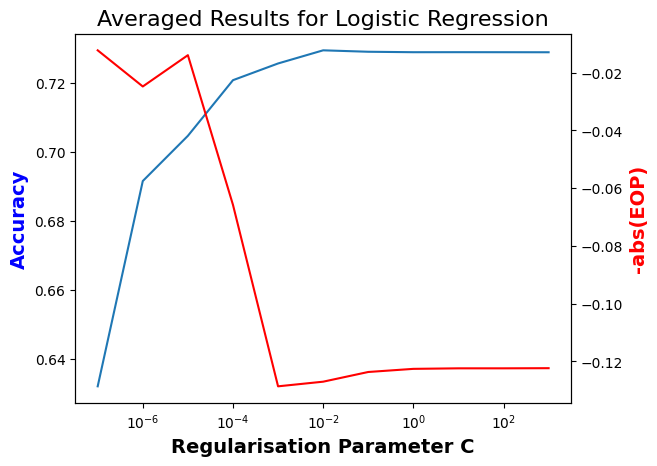

In [44]:
def plot_results(results, title):
    # Plot the averaged results of the 5 train/val splits
    values = results.values()
    accuracies = [x[0] for x in values]
    stat_par_diffs = [-abs(x[1]) for x in values]
    C_values = results.keys()
    # Plot the accuracies on one axis and the statistical parity differences on another
    ax1 = plt.gca()
    ax1.plot(C_values, accuracies)
    ax1.set_xlabel('Regularisation Parameter C', fontweight='bold', fontsize=14)
    ax1.set_xscale('log')
    ax1.set_ylabel('Accuracy', color='b', fontweight='bold', fontsize=14)

    # Plot the statistical parity differences on the same axis
    ax2 = ax1.twinx()
    ax2.plot(C_values, stat_par_diffs, color='r')
    ax2.set_ylabel('-abs(EOP)', color='r', fontweight='bold', fontsize=14)

    plt.title(title, fontsize=16)
    plt.show()

plot_results(averaged_results, "Averaged Results for Logistic Regression")

In [10]:
# Task 2:
# This looks very similar to before, but first using some fairness-aware method.
# Will start with the simplest one: Reweighing


# First, we will reweigh the training set
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train_dataset)
train_dataset_reweighed = RW.transform(train_dataset)


train_val_splits_reweighed = get_train_val_splits(train, reweigh = True)


# Perform hyperparameter tuning and evaluation as before
model_3, model_4, reweighed_average_results = hyperparameter_tuning(train_dataset_reweighed, train_val_splits_reweighed, unprivileged_groups, privileged_groups, reweighing = True)

model_3_scores = evaluate_model(model_3)
model_4_scores = evaluate_model(model_4)
print("Model 3 Accuracy: ", model_3_scores[0])
print("Model 3 Statistical Parity Difference: ", model_3_scores[1]['EOD'])
print("Model 4 Accuracy: ", model_4_scores[0])
print("Model 4 Statistical Parity Difference: ", model_4_scores[1]['EOD'])


C:  1e-07
Validation Accuracy:  0.6309794666037292
Validation Absolute Equality of Opportunity:  0.014242763399419812
C:  1e-06
Validation Accuracy:  0.690106207222091
Validation Absolute Equality of Opportunity:  0.02747212594258621
C:  1e-05
Validation Accuracy:  0.7031720556997876
Validation Absolute Equality of Opportunity:  0.025169896173913055
C:  0.0001
Validation Accuracy:  0.7201274486665092
Validation Absolute Equality of Opportunity:  0.009146577021341029
C:  0.001
Validation Accuracy:  0.7290866178900166
Validation Absolute Equality of Opportunity:  0.03957096697468467
C:  0.01
Validation Accuracy:  0.7300118008024545
Validation Absolute Equality of Opportunity:  0.03413769409314891
C:  0.1
Validation Accuracy:  0.7295303280623082
Validation Absolute Equality of Opportunity:  0.029721328276510906
C:  1
Validation Accuracy:  0.7292943120132168
Validation Absolute Equality of Opportunity:  0.028794713569585028
C:  10
Validation Accuracy:  0.7292565494453622
Validation Absolut

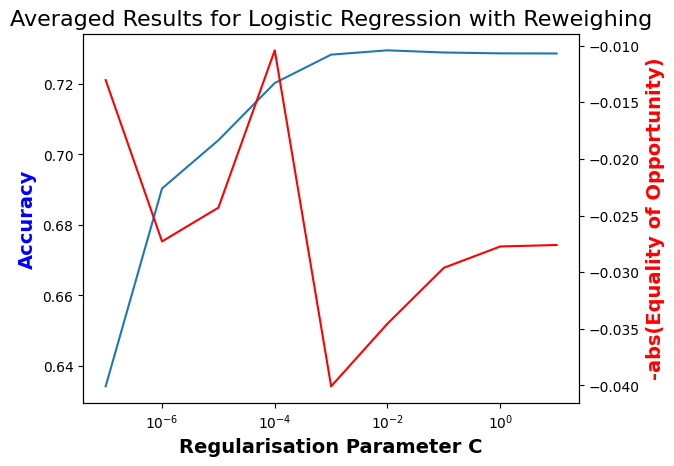

In [30]:
plot_results(reweighed_average_results, "Averaged Results for Logistic Regression with Reweighing")

In [32]:
# Model 5:
train_val_splits_orig = get_train_val_splits(train, reweigh = False)

model_5, model_5_results = hyperparameter_tuning(train_dataset, train_val_splits_orig, unprivileged_groups, privileged_groups, reweighing = False, custom_criterion = True)

print("buggo")
# Model 6:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train_dataset)
train_dataset_reweighed = RW.transform(train_dataset)


train_val_splits_reweighed = get_train_val_splits(train, reweigh = True)


# Perform hyperparameter tuning and evaluation as before
model_6, model_6_results = hyperparameter_tuning(train_dataset_reweighed, train_val_splits_reweighed, unprivileged_groups, privileged_groups, reweighing = True, custom_criterion = True)

C:  1e-07
Validation Accuracy:  0.629506726457399
Validation Absolute Equality of Opportunity:  0.011769651548069948
C:  1e-06
Validation Accuracy:  0.6898418692471089
Validation Absolute Equality of Opportunity:  0.021765784805634424
C:  1e-05
Validation Accuracy:  0.703379749822988
Validation Absolute Equality of Opportunity:  0.011626450921182419
C:  0.0001
Validation Accuracy:  0.719726221383054
Validation Absolute Equality of Opportunity:  0.0635880009429034
C:  0.001
Validation Accuracy:  0.7242718904885532
Validation Absolute Equality of Opportunity:  0.12618748855957745
C:  0.01
Validation Accuracy:  0.7274817087561954
Validation Absolute Equality of Opportunity:  0.12474979872790022
C:  0.1
Validation Accuracy:  0.7269766344111399
Validation Absolute Equality of Opportunity:  0.12138824674794821
C:  1
Validation Accuracy:  0.7267689402879396
Validation Absolute Equality of Opportunity:  0.12018053207820578
C:  10
Validation Accuracy:  0.7267264573991032
Validation Absolute Equ

In [36]:
model_5_scores = evaluate_model(model_5)
model_6_scores = evaluate_model(model_6)
print("Model 5 Accuracy: ", model_5_scores[0])
print("Model 5 Equality of Opportunity: ", model_5_scores[1]['EOD'])
print("Model 6 Accuracy: ", model_6_scores[0])
print("Model 6 Equality of Opportunity: ", model_6_scores[1]['EOD'])

Model 5 Accuracy:  0.7064499074808354
Model 5 Equality of Opportunity:  0.014354349486469853
Model 6 Accuracy:  0.7220680236144154
Model 6 Equality of Opportunity:  0.010401979770105707


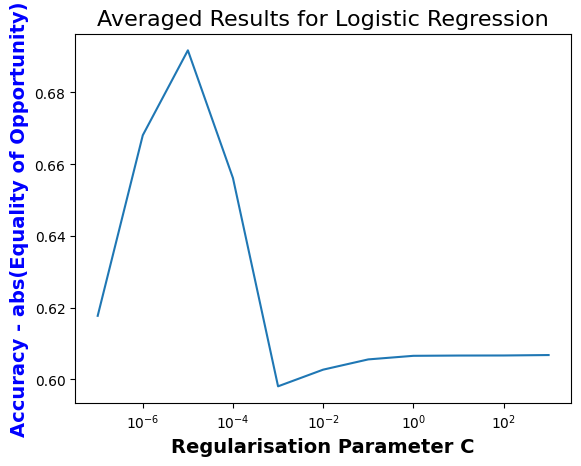

In [39]:
# Plot model 5 results
values = model_5_results
C_values = [1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Plot the accuracies on one axis and the statistical parity differences on another
plt.plot(C_values, values)
plt.xlabel('Regularisation Parameter C', fontweight='bold', fontsize=14)
plt.xscale('log')
plt.ylabel('Accuracy - abs(EoO)', color='b', fontweight='bold', fontsize=14)
plt.title("Averaged Results for Logistic Regression", fontsize=16)
plt.show()

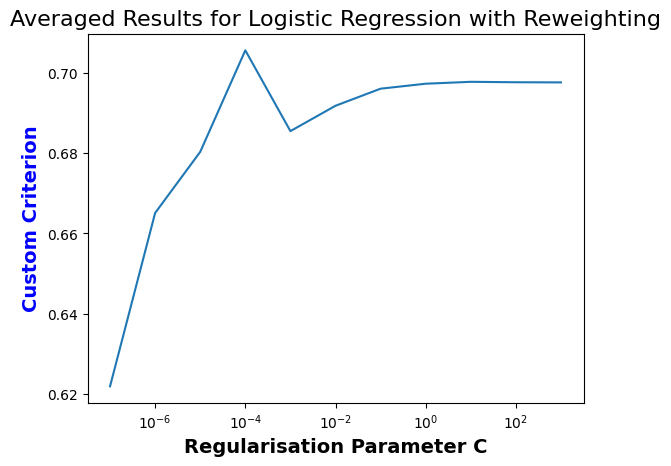

In [38]:
# Plot model 5 results
values = model_6_results
C_values = [1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# 
plt.plot(C_values, values)
plt.xlabel('Regularisation Parameter C', fontweight='bold', fontsize=14)
plt.xscale('log')
plt.ylabel('Accuracy - abs(EoO)', color='b', fontweight='bold', fontsize=14)
plt.title("Averaged Results for Logistic Regression with Reweighting", fontsize=16)
plt.show()